# Convert drone labels to true bbox

-----

In [99]:
import pandas as pd
import numpy as np

In [41]:
data = pd.read_csv('/data/train_labels.csv')

In [42]:
data_orig = data.copy()

In [43]:
data = data_orig.copy()

In [44]:
data.shape

(422053, 12)

In [45]:
data = data[data['lost'] != 1]
data = data[data['occluded'] != 1]

In [46]:
data.sample(4)

,track_id,x_min,y_min,x_max,y_max,frame,lost,occluded,generated,label,actions,video
338087,49,1756,863,1838,1048,1237,0,0,1,Person,Walking,2.1.5
133632,76,1697,376,1771,503,1343,0,0,1,Person,Carrying,1.2.4
317529,33,2091,387,2130,483,583,0,0,1,Person,Standing,1.1.1
161089,29,1501,2009,1605,2088,662,0,0,1,Person,Standing,1.1.4


In [47]:
data = data[['track_id','x_min','y_min','x_max','y_max','frame','video','lost','occluded','generated','label']]

In [48]:
data.shape

(316435, 11)

In [49]:
data = data.drop_duplicates()

In [50]:
data.shape

(316435, 11)

In [51]:
video = '1.1.11'
tmp = data[data['video'] == video]

## Convert to true bbox

In [78]:
row = tmp[tmp['frame'] == 0]
row

,track_id,x_min,y_min,x_max,y_max,frame,video,lost,occluded,generated,label
363565,0,1020,1520,1113,1599,0,1.1.11,0,0,0,Person


In [54]:
# Xmin Ymin Xmax Ymax
# Xmiddle Ymiddle Width Height
# 13, 13, 3, 5 + 80

In [57]:
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
import cv2

In [72]:
img_path = '/data/train/1.1.11_0.jpg'

image = cv2.imread(img_path) / 255
# image = img_to_array(image) / 255

In [108]:
image.shape

(720, 1280, 3)

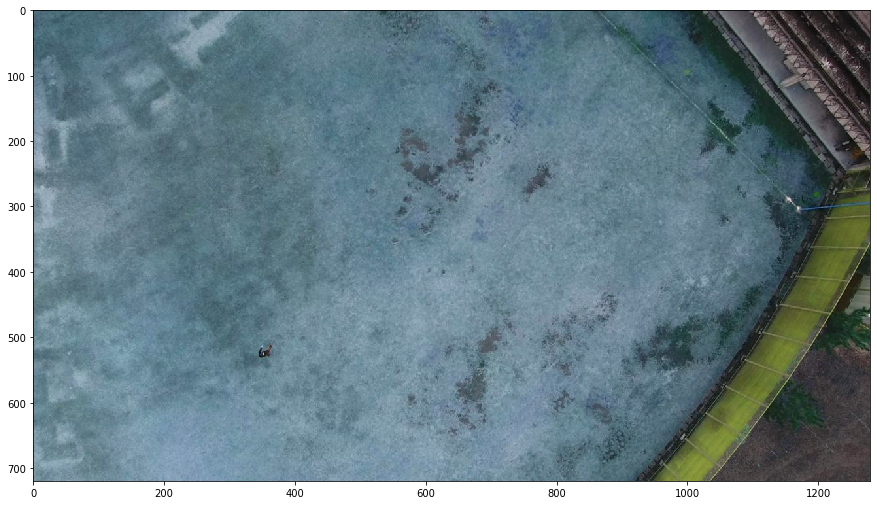

In [73]:
fig, ax = plt.subplots(figsize=(15,10))
plt.imshow(image)
plt.show()

In [ ]:
# Step 1 : Resize to yolo input image size ==> (416,416,3)

In [89]:
img_h_orig, img_w_orig, _ = image.shape

In [75]:
image_resize = cv2.resize(image, (416,416))

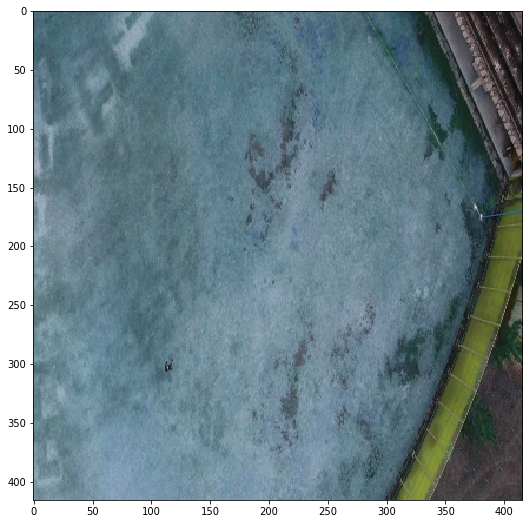

In [77]:
fig, ax = plt.subplots(figsize=(9,9))
plt.imshow(image_resize)
plt.show()

In [83]:
# Step 2 retrieve my x,y min,max of ALL objects in a frame 
xyx_y_ = row[['x_min','y_min','x_max','y_max']].values

In [84]:
xyx_y_

array([[1020, 1520, 1113, 1599]])

In [ ]:
# ==> (grid_w, grid_h, 3, 5)

In [135]:
# Step 3 : init parameters
grid = (4,4)
grid_h, grid_w = grid
img_h, img_w, _ = image_resize.shape

scale_w_orig = img_w / (img_w_orig*3)
scale_h_orig = img_h / (img_h_orig*3)

cell_h, cell_w = img_h / grid_h, img_w / grid_w

iou_threshold = 0.3

anchors = [(0.2,0.2), (0.5,0.2), (0.2,0.5)]
nb_anchors = len(anchors)
num_class = 0

In [136]:
3840/1280, 2160/720

(3.0, 3.0)

In [137]:
cell_h, cell_w

(104.0, 104.0)

In [138]:
bboxes_true = np.zeros(shape=(grid_h, grid_w, nb_anchors, 5+num_class))
bboxes_true.shape

(4, 4, 3, 5)

In [158]:
def bboxes_iou(boxes1, boxes2):

    boxes1 = np.array(boxes1)
    boxes2 = np.array(boxes2)

    boxes1_area = (boxes1[..., 2] - boxes1[..., 0]) * (boxes1[..., 3] - boxes1[..., 1])
    boxes2_area = (boxes2[..., 2] - boxes2[..., 0]) * (boxes2[..., 3] - boxes2[..., 1])

    left_up       = np.maximum(boxes1[..., :2], boxes2[..., :2])
    right_down    = np.minimum(boxes1[..., 2:], boxes2[..., 2:])

    inter_section = np.maximum(right_down - left_up, 0.0)
    inter_area    = inter_section[..., 0] * inter_section[..., 1]
    union_area    = boxes1_area + boxes2_area - inter_area
    ious          = np.maximum(1.0 * inter_area / union_area, np.finfo(np.float32).eps)

    return ious

bboxes_true = np.zeros(shape=(grid_h, grid_w, nb_anchors, 5+num_class))

for num_row in range(grid_h):
    for num_col in range(grid_w):

        for box in xyx_y_:
            # Retrieve xmin,ymin,xmax,ymax
            xmin, ymin, xmax, ymax = box

            # Scale to new image size (from 3840x2160 ==> 416x416)
            xmin = xmin * scale_w_orig
            xmax = xmax * scale_w_orig
            ymin = ymin * scale_h_orig
            ymax = ymax * scale_h_orig
            
            # print(xmin, ymin, xmax, ymax)
            width = (xmax - xmin)
            height = (ymax - ymin)
            xmid = xmin + (width / 2)
            ymid = ymin + (height / 2)
            
            xmin_cell = num_col * cell_w
            xmax_cell = xmin_cell + cell_w
            ymin_cell = num_row * cell_h
            ymax_cell = ymin_cell+cell_h
            
            # Is my middle point in the cell ? 
            if (xmid >= xmin_cell) & (xmid < xmax_cell) & (
                ymid >= ymin_cell) & (ymid < ymax_cell):
                
                # print('WOW', num_row, num_col)
                
                # Scale value to percenatge of the cell shape
                xmid = (xmid - xmin_cell) / cell_w
                ymid = (ymid - ymin_cell) / cell_h
                height = height / cell_h
                width = width / cell_w
                
                obj_box = ((xmin - xmin_cell) / cell_w, 
                           (ymin - ymin_cell) / cell_h, 
                           (xmax - xmin_cell) / cell_w, 
                           (ymax - ymin_cell) / cell_h)
                
                ious = list()
                for anchor in anchors:
                    h_anchor, w_anchor = anchor
                    
                    anchor_box = (xmid-(w_anchor/2), ymid-(h_anchor/2),
                                  xmid+(w_anchor/2), ymid+(h_anchor/2))
                    
                    iou = bboxes_iou(anchor_box, obj_box)
                    ious.append(iou)
                    
                ok = False
                for idx, iou in enumerate(ious):
                    if iou > iou_threshold:
                        ok = True
                        bboxes_true[num_row, num_col, idx] = [1, xmid, ymid, height, width]
                        
                if not ok:
                    best = np.argmax(ious)
                    bboxes_true[num_row, num_col, best] = [1, xmid, ymid, height, width]

## Plot from bboxes true

In [190]:
bboxes_true.shape

(4, 4, 3, 5)

In [194]:
bboxes_true[...,0][2]

array([[0., 0., 0.],
       [1., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.]])

In [196]:
bboxes_true[:,2,]

array([[[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]],

       [[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]],

       [[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]],

       [[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]]])

In [161]:
num_row, num_col, num_anchors, _ = bboxes_true.shape

In [163]:
image_resize.shape

(416, 416, 3)

In [164]:
cell_w, cell_h

(104.0, 104.0)


cell: 0 0
(3, 5)
False
[0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0.]

cell: 0 1
(3, 5)
False
[0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0.]

cell: 0 2
(3, 5)
False
[0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0.]

cell: 0 3
(3, 5)
False
[0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0.]

cell: 1 0
(3, 5)
False
[0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0.]

cell: 1 1
(3, 5)
False
[0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0.]

cell: 1 2
(3, 5)
False
[0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0.]

cell: 1 3
(3, 5)
False
[0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0.]

cell: 2 0
(3, 5)
False
[0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0.]

cell: 2 1
(3, 5)
True
[1.         0.1109375  0.88796296 0.1462963  0.096875  ]
[0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0.]

cell: 2 2
(3, 5)
False
[0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0.]

cell: 2 3
(3, 5)
False
[0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0.]

cell: 3 0
(3, 5)
False
[0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0.]
[0.

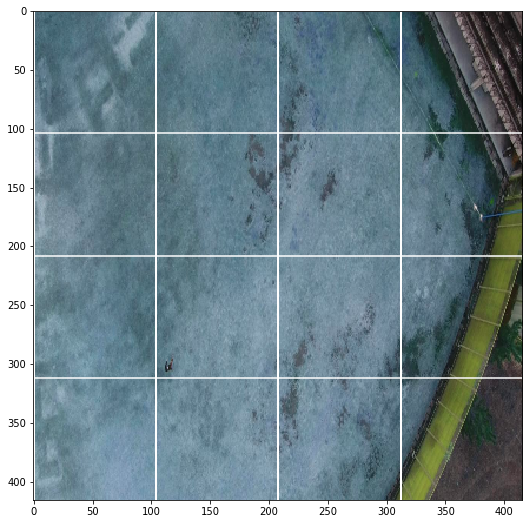

In [189]:
fig, ax = plt.subplots(figsize=(9,9))
plt.imshow(image_resize)

for row in range(num_row):
    plt.axhline(y=row*cell_h, color='w')
    
    for col in range(num_col):
        plt.axvline(x=col*cell_w, color='w')

        boxes = bboxes_true[row, col]
        print()
        print('cell:', row, col)    
        print(boxes.shape)
        print(any(boxes[:,0] > 0.5))
        for box in boxes:
            print(box)

        if row == 2 & col == 1:
            lol()

plt.show()